In [ ]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json

In [ ]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1-2].shp")
#shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

The code below (used when all hru shapefiles are read) is not optimum because it's base on the centroid of the hrus.  Therefore these boundary values are better and cover hrus outside the conus -126 54 -65 23

In [3]:
type(gdf['geometry'].bounds['minx'])
west = gdf['geometry'].bounds['minx'].min()
east = gdf['geometry'].bounds['maxx'].max()
south = gdf['geometry'].bounds['miny'].min()
north = gdf['geometry'].bounds['maxy'].max()
print(west, north, east, south)

-80.54027121799999 48.100042571000074 -66.94953853699997 36.64632387200004


#### Some example URLs for tmax

https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4?var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&horizStride=1&time_start=2018-01-01T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf

https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4?var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&disableProjSubset=on&horizStride=1&time_start=2018-01-01T12%3A00%3A00Z&time_end=2018-01-01T12%3A00%3A00Z&timeStride=1&accept=netcdf
 


In [ ]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode

prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4'
prcppayload = {
    'var': 'lat&var=lon&var=tmax',
    'north': '54',
    'west': '-126',
    'east': '-65',
    'south': '23',
    'disableProjSubset': 'on',
    'horizStride': '1',
    'time_start': '2018-12-31T00:00:00Z',
    'time_end': '2018-12-31T00:00:00Z',
    'timeStride': '1',
    'accept': 'netcdf'}    
try:
    s = requests.Session()
    #https://github.com/psf/requests/issues/1454
    qry = urlencode(prcppayload).replace('%26','&')
    qry = qry.replace('%3D', '=')
    print(qry)
    tmaxfile = requests.get(prcpurl, params=qry)
    tmaxfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occured: {http_err}')
except Exception as err:
    print(f'Other error occured: {err}')
else:
    print('Gridmet data retrieved!')

In [ ]:
with open('tmax_test2.nc', 'wb') as fh:
    fh.write(tmaxfile.content)
fh.close

In [4]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)
# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
# lonres = float(ds.attrs['geospatial_lon_resolution'])
# latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 5904, y: 3377)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -1688.0 -1689.0
  * x                        (x) float32 -2650.25 -2649.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-30T12:00:00
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2
    start_year:          2018
    source:              Daymet Software Version 3.0
    Version_software:    Daymet Software Version 3.0
    Version_data:        Daymet Data Version 3.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor..

In [ ]:
ds.variables.keys()

In [ ]:
tmax = ds.variables['tmax'][:]  # Reads the whole array
tmax

In [ ]:
ds.tmax.plot()

In [ ]:
f1, ax1 = plt.subplots(1)
ax1.set_aspect('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=0)
print(type(ptmax_1))
print(ptmax_1.shape)
# ptmax_1.plot(ax=ax1, x='x', y='y', cmap='viridis')
ds.tmax.plot(ax=ax1, x='x', y='y')
f1.tight_layout()
f1.savefig('daymet.png')

In [ ]:
import cartopy.crs as ccrs
ax = plt.subplot(projection=ccrs.PlateCarree());
ds.tmax.plot(ax=ax);
# ax.scatter(ds.lon, ds.lat, transform=ccrs.PlateCarree(),s=0.001);
# ax.coastlines(); 
ax.gridlines(draw_labels=True);
fig = plt.gcf()
fig.set_size_inches(15,15)

In [ ]:
for i in range(1,10): print(i)

In [5]:
lon = ds.lon.values
lat = ds.lat.values
print(np.shape(lon)[0], np.shape(lon)[1])

3377 5904


In [ ]:
from shapely.geometry import Polygon
def distance(p1x, p1y, p2x, p2y):
    return np.sqrt(np.power((p2x-p1x),2) + np.power((p2y-p1y),2))

#first create dataframe with temp
df = pd.DataFrame({'temperature': ds.tmax.values.flatten()})
res = 0.04166666/2.0
numcells = (np.shape(lat)[0]-2)*(np.shape(lat)[1]-2) # -2 to ignore boundaries, daymet domain should well overlap conus
poly = []
index = np.zeros(numcells)
count = 0
# ncfcell = gpd.GeoDataFrame()
# ncfcell['geometry'] = None

for i in range(1, np.shape(lon)[0]-1):
    if i%10 == 0: print(i)
    for j in range(1, np.shape(lon)[1]-1):
        l1 = distance(lon[i,j], lat[i,j], lon[i,j-1], lat[i,j-1])/2.0
        l2 = distance(lon[i,j], lat[i,j], lon[i+1,j], lat[i+1,j])/2.0
        l3 = distance(lon[i,j], lat[i,j], lon[i,j-1], lat[i,j-1])/2.0
        l4 = distance(lon[i,j], lat[i,j], lon[i-1,j], lat[i-1,j])/2.0
        
        lon_point_list = [lon[i,j]+l2, lon[i,j]+l2, lon[i,j]-l4, lon[i,j]-l4]
        lat_point_list = [lat[i,j]-l1, lat[i,j]+l3, lat[i,j]+l3, lat[i,j]-l1]
        
        poly.append(Polygon(zip(lon_point_list, lat_point_list)))
        index[count] = count
        count += 1
# ncfcells = gpd.GeoDataFrame(df, index=index, crs=ds['crs'], geometry=poly)  
ncfcells = gpd.GeoDataFrame(df, index=index, geometry=poly)  
ncfcells.head()

In [ ]:
ncfcells.to_csv('daymet_cells.csv')

In [ ]:
len(ncfcells)

In [ ]:
ncfcells[len(ncfcells)-10:len(ncfcells)].plot()

In [ ]:
ncfcells[0:10].plot()

In [ ]:
spatial_index = ncfcells.sindex
print(type(gdf.loc[[0]]))

import csv
tcount = 0
with open('daymet_weights_t.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        count = 0
        if tcount == 0:
            writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
        possible_matches_index = list(spatial_index.intersection(row['geometry'].bounds))
        possible_matches = ncfcells.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
        res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
        for nindex, row in res_intersection.iterrows():
            tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
            writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
            count += 1
        tcount += 1
        print(tcount, index)

In [6]:
from shapely.geometry import Polygon
def distance(p1x, p1y, p2x, p2y):
    return np.sqrt(np.power((p2x-p1x),2) + np.power((p2y-p1y),2))

#first create dataframe with temp
df = pd.DataFrame({'temperature': ds.tmax.values.flatten()})
res = 0.04166666/2.0
numcells = (np.shape(lat)[0]-2)*(np.shape(lat)[1]-2) # -2 to ignore boundaries, daymet domain should well overlap conus
poly = []
index = np.zeros(numcells)
count = 0
# ncfcell = gpd.GeoDataFrame()
# ncfcell['geometry'] = None

for i in range(1, np.shape(lon)[0]-1):
    if i%10 == 0: print(i)
    for j in range(1, np.shape(lon)[1]-1):
        
        tpoly_1_lon = [lon[i,j], lon[i,j-1], lon[i+1,j-1], lon[i+1, j]]
        tpoly_1_lat = [lat[i,j], lat[i,j-1], lat[i+1,j-1], lat[i+1, j]]
        tpoly_1 = Polygon(zip(tpoly_1_lon, tpoly_1_lat))
        p1 = tpoly_1.centroid
        
        tpoly_2_lon = [lon[i,j], lon[i+1,j], lon[i+1,j+1], lon[i, j+1]]
        tpoly_2_lat = [lat[i,j], lat[i+1,j], lat[i+1,j+1], lat[i, j+1]]
        tpoly_2 = Polygon(zip(tpoly_2_lon, tpoly_2_lat))
        p2 = tpoly_2.centroid  
        
        tpoly_3_lon = [lon[i,j], lon[i,j+1], lon[i-1,j+1], lon[i-1, j]]
        tpoly_3_lat = [lat[i,j], lat[i,j+1], lat[i-1,j+1], lat[i-1, j]]
        tpoly_3 = Polygon(zip(tpoly_3_lon, tpoly_3_lat))
        p3 = tpoly_3.centroid  

        tpoly_4_lon = [lon[i,j], lon[i-1,j], lon[i-1,j-1], lon[i, j-1]]
        tpoly_4_lat = [lat[i,j], lat[i-1,j], lat[i-1,j-1], lat[i, j-1]]
        tpoly_4 = Polygon(zip(tpoly_4_lon, tpoly_4_lat))
        p4 = tpoly_4.centroid  
        
#         l1 = distance(lon[i,j], lat[i,j], lon[i,j-1], lat[i,j-1])/2.0
#         l2 = distance(lon[i,j], lat[i,j], lon[i+1,j], lat[i+1,j])/2.0
#         l3 = distance(lon[i,j], lat[i,j], lon[i,j-1], lat[i,j-1])/2.0
#         l4 = distance(lon[i,j], lat[i,j], lon[i-1,j], lat[i-1,j])/2.0
        
#         lon_point_list = [lon[i,j]+l2, lon[i,j]+l2, lon[i,j]-l4, lon[i,j]-l4]
#         lat_point_list = [lat[i,j]-l1, lat[i,j]+l3, lat[i,j]+l3, lat[i,j]-l1]
        
        lon_point_list = [p1.x, p2.x, p3.x, p4.x]
        lat_point_list = [p1.y, p2.y, p3.y, p4.y]
        
        poly.append(Polygon(zip(lon_point_list, lat_point_list)))
        index[count] = count
        count += 1
# ncfcells = gpd.GeoDataFrame(df, index=index, crs=ds['crs'], geometry=poly)  
ncfcells = gpd.GeoDataFrame(df, index=index, geometry=poly)  
ncfcells.head()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

,temperature,geometry
0.0,NaN,POLYGON ((-141.6904294091425 51.98694160502199...
1.0,NaN,POLYGON ((-141.6771850585938 51.99140548706055...
2.0,NaN,POLYGON ((-141.6639407080997 51.99586746181224...
3.0,NaN,POLYGON ((-141.6506930550548 52.00032848864491...
4.0,NaN,POLYGON ((-141.6374435424805 52.00478744506836...


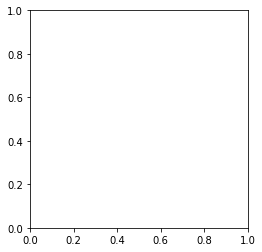

In [34]:
ncfcells[len(ncfcells)-10:len(ncfcells)].plot()

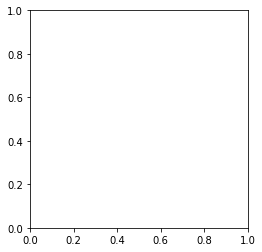

In [33]:
ncfcells[0:10].plot()

In [9]:
ncfcells.dropna(subset=['temperature'], inplace=True)

In [10]:
ncfcells.index

Float64Index([     679.0,      680.0,      681.0,      682.0,      683.0,
                   684.0,      685.0,      686.0,      687.0,      688.0,
              ...
              19917090.0, 19917091.0, 19917092.0, 19917103.0, 19917104.0,
              19917105.0, 19918757.0, 19918758.0, 19918759.0, 19918760.0],
             dtype='float64', length=12351931)

In [ ]:
ncfcells.to_csv('daymet_cells.csv')

In [ ]:
ncfcells = gpd.read_file('daymet_cells.csv')

In [11]:
spatial_index = ncfcells.sindex
# print(type(gdf.loc[[0]]))
ncfcells.sindex

In [ ]:
print(type(spatial_index))
spatial_index


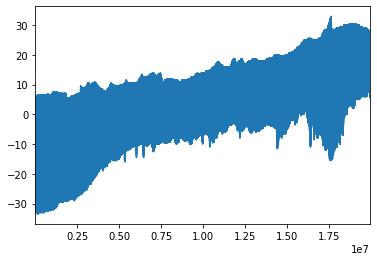

In [39]:
hru_1_ind =[8816431,8816432,8834138,8834137,8840039,8834140,8834139,
            8845943,8851844,8851845,8822334,8822333,8828235,8822335,
            8828237,8828236,8840041,8840040,8845942,8845941,8840042]
# ncfcells.temperature[hru_1_ind].plot()
ncfcells.temperature.plot()
# print(type(ncfcells))
# ax.plot()

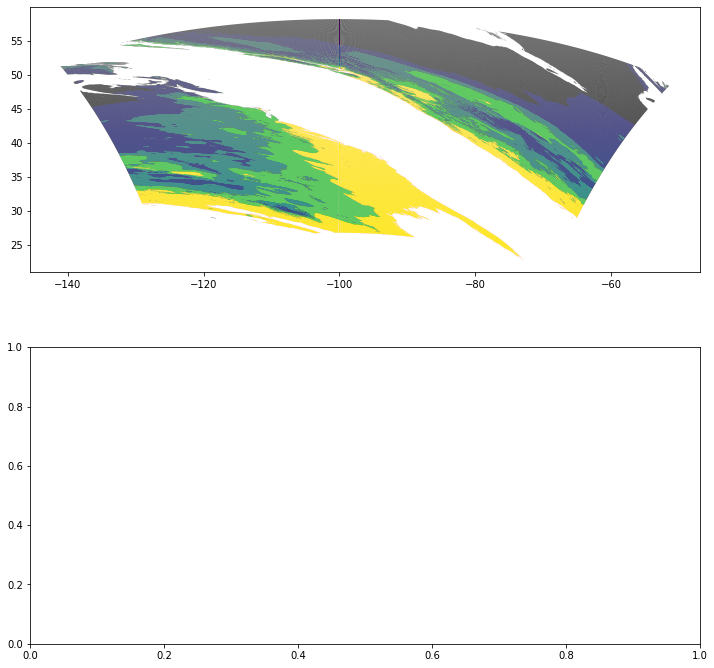

In [40]:
f, ax = plt.subplots(2, figsize=(12,12))
ncfcells.plot(ax=ax[0], column = 'temperature',linewidth=0., edgecolor='white', scheme='quantiles')

In [15]:
hru_1_ind

[8816431,
 8816432,
 8834138,
 8834137,
 8840039,
 8834140,
 8834139,
 8845943,
 8851844,
 8851845,
 8822334,
 8822333,
 8828235,
 8822335,
 8828237,
 8828236,
 8840041,
 8840040,
 8845942,
 8845941,
 8840042]

In [42]:

import csv
tcount = 0
with open('tmp_weights.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        count = 0
        if tcount == 0:
            writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
        possible_matches_index = list(spatial_index.intersection(row['geometry'].bounds))
        possible_matches = ncfcells.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
        res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
        for nindex, row in res_intersection.iterrows():
            tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
            writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
            count += 1
        tcount += 1
        if tcount == 1:
            break
        print(tcount, index)

0     0.000029
1     0.000080
2     0.000077
3     0.000022
4     0.000023
5     0.000097
6     0.000028
7     0.000117
8     0.000001
9     0.000118
10    0.000004
11    0.000116
12    0.000021
13    0.000093
14    0.000050
15    0.000012
16    0.000060
17    0.000076
18    0.000011
19    0.000034
20    0.000006
dtype: float64 0.0010739152360807382 0    0.001074
dtype: float64


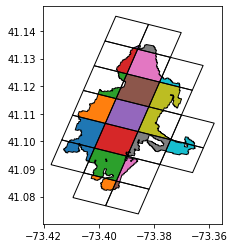

In [43]:
ax = res_intersection.plot(cmap='tab10')
ax = gdf.loc[[0], 'geometry'].plot(ax=ax, facecolor='none', edgecolor='k')
precise_matches.plot(ax=ax, facecolor='none', edgecolor='k')
print(res_intersection.area, np.sum(res_intersection.area), gdf.loc[[0], 'geometry'].area)

In [ ]:
print(ds.lon.shape)
x1 = ds.lon[1,1].values
y1 = ds.lat[1,1].values
x2 = ds.lon[2,1].values
y2 = ds.lat[2,1].values
latdist = np.sqrt(np.power(x2-x1, 2) + np.power(y2-y1,2))
print(latdist)
print(latdist*4)
x1 = ds.lon[1,1].values
y1 = ds.lat[1,1].values
x2 = ds.lon[1,2].values
y2 = ds.lat[1,2].values
latdist = np.sqrt(np.power(x2-x1, 2) + np.power(y2-y1,2))
print(latdist)
print(latdist*4)
# print(ds.lon[2,1].values, ds.lon[1,1].values)
# print((ds.lon[2,1].values - ds.lon[1,1].values))
# print(ds.lat[2,1].values, ds.lat[1,1].values)
# print(ds.lat[2,1].values - ds.lat[1,1].values)

In [ ]:
for i in range(1,11):
    x1 = ds.lon[i,1].values
    y1 = ds.lat[i,1].values
    x2 = ds.lon[i+1,1].values
    y2 = ds.lat[i+1,1].values
    latdist = np.sqrt(np.power(x2-x1, 2) + np.power(y2-y1,2))
    print(latdist)
for i in range(1,11):
    x1 = ds.lon[1,i].values
    y1 = ds.lat[1,i].values
    x2 = ds.lon[1,i+1].values
    y2 = ds.lat[1,i+1].values
    latdist = np.sqrt(np.power(x2-x1, 2) + np.power(y2-y1,2))
    print(latdist)

In [ ]:
print(np.nanmean(ptmax_1.values))
print(np.nanmin(ptmax_1.values))
print(np.nanmax(ptmax_1.values))

ptmax_1

In [ ]:
earth_radius = 6371008.7714
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

def change_in_latitude(m):
    "Given a distance north, return the change in latitude."
    return (m/earth_radius)*radians_to_degrees

def change_in_longitude(latitude, m):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (m/r)*radians_to_degrees

print(change_in_latitude(1000.0), change_in_longitude(40, 1000.0))
print(change_in_latitude(4000.0), change_in_longitude(40, 4000.0))